In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import tensorflow as tf

from keras.models import Model
from PIL import Image
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Initialize functions and generator for training and evaluation

In [19]:
def myGenerator(gen1, gen2):
    """Combine generators of imbalanced datasets into one.
    
    Args:
        gen1 (generator): First generator of image data split
            by classes
        gen2 (generator): Second generator of image data split
            by classes
        
    Returns:
        gen3 (generator): Generator that combines 2 generators
    """
    while True:
        img_data1,label1 = next(gen1)
        img_data2,label2 = next(gen2)
        if ((label1.shape[0] + label2.shape[0]) % 32) != 0:
            img_data1, label1 = next(gen1)
            img_data2, label2 = next(gen2)
        img_data_c = np.concatenate((img_data1, img_data2))

        label_size = label1.shape[1] + label2.shape[1]
        new_labels1 = np.zeros((label1.shape[0], label_size))
        new_labels1[:, :-label2.shape[1]] = label1
        new_labels2 = np.zeros((label2.shape[0], label_size))
        new_labels2[:, label1.shape[1]:] = label2

        labels_c = np.concatenate((new_labels1, new_labels2), axis=0)

        shuffler = np.random.permutation(labels_c.shape[0])
        labels_c_shuffled = labels_c[shuffler]
        img_data_c_shuffled = img_data_c[shuffler]

        yield img_data_c_shuffled, labels_c_shuffled

def plot_accuracy(history_obj, title):
    """Plots trained ML model accuracy scores.
    
    Args:
        history_df (obj): Output object from trained ML model 
        title (str): The desired title of the plot
        
    Returns:
        None
    """
    data_acc_df = pd.DataFrame({
        'epoch':[*range(1, len(
            history_obj.history['categorical_accuracy']) + 1)],
        'accuracy':history_obj.history['categorical_accuracy']}) 
    data_acc_df['Data'] = 'training'
    data_vacc_df = pd.DataFrame({
        'epoch':[*range(1, len(
            history_obj.history['val_categorical_accuracy']) + 1)],
        'accuracy':history_obj.history['val_categorical_accuracy']})
    data_vacc_df['Data'] = 'validation'
    data_m_df = pd.concat((data_acc_df, data_vacc_df), axis=0)

    plt.figure(figsize=(12, 5))
    sns.lineplot(data=data_m_df, x='epoch', y='accuracy', hue='Data')
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.title(title, fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim((0.1, 0.9))
    plt.show()
    
# Set up plot styling
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-notebook')

In [20]:
# Initialize training generator
train_datagen= ImageDataGenerator(
        rotation_range=90,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1./255,
        fill_mode='nearest',
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=30,
        zoom_range=0.1,
        brightness_range=[0.7, 1.0])
train_generator_1 = train_datagen.flow_from_directory(
        'model_dataset/train/augment',
        target_size=(200, 200),
        batch_size=26,
        class_mode='categorical',
        shuffle=True,
        seed=15)
train_generator_2 = train_datagen.flow_from_directory(
        'model_dataset/train/no_augment',
        target_size=(200, 200),
        batch_size=6,
        class_mode='categorical',
        shuffle=True,
        seed=15)
train_generator = myGenerator(train_generator_1, train_generator_2)

# Initialize validation generator
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(
        'model_dataset/validation',
        target_size=(200, 200),
        batch_size=32,
        shuffle = True,
        class_mode='categorical')

# Initialize test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory='model_dataset/test',
    target_size=(200, 200),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
    seed=42)

Found 280 images belonging to 4 classes.
Found 440 images belonging to 1 classes.
Found 75 images belonging to 5 classes.
Found 75 images belonging to 5 classes.


# 2. Train the optimized CNN, SVM and Random Forest models

In [21]:
steps_per_epoch = 10

In [22]:
# Weight Layers: 7 | Activation: Relu | Max Filter: 256 | Max FCN: 128
feat_extract = models.Sequential()
feat_extract.add(layers.Conv2D(64, (3, 3), activation='relu', 
                        input_shape=(200, 200, 3)))
feat_extract.add(layers.Conv2D(64, (3, 3), activation='relu'))
feat_extract.add(layers.MaxPooling2D((2, 2)))
feat_extract.add(layers.Conv2D(128, (3, 3), activation='relu'))
feat_extract.add(layers.Conv2D(128, (3, 3), activation='relu'))
feat_extract.add(layers.MaxPooling2D((2, 2)))
feat_extract.add(layers.Conv2D(256, (3, 3), activation='relu'))
feat_extract.add(layers.Conv2D(256, (3, 3), activation='relu'))
feat_extract.add(layers.MaxPooling2D((2, 2)))
feat_extract.add(layers.Flatten())

x = feat_extract.output
x = layers.Dense(128, activation='relu')(x)
x =layers.Dropout(0.2)(x)
prediction_layer = layers.Dense(5, activation='softmax')(x)

# Train CNN model
vgg16 = Model(inputs=feat_extract.input, outputs=prediction_layer)
vgg16.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['CategoricalAccuracy'])

history_vgg16 = vgg16.fit(train_generator, steps_per_epoch=steps_per_epoch,
                          epochs=75, validation_data=valid_generator,
                          validation_steps=2, verbose=0)

In [24]:
# Extract train features for SVM model
for i in range(steps_per_epoch):
    (X_sub, y_sub) = next(train_generator)
    y_sub = np.argmax(y_sub, axis=1)
    if i == 0:
        X_train = X_sub.copy()
        y_train = y_sub.copy()
    else:
        X_train = np.append(X_train, X_sub, axis=0)
        y_train = np.append(y_train, y_sub, axis=0)
X_ext_train = feat_extract.predict(X_train)

# Extract validation features for CNN and SVM model
for i in range(3):
    (X_sub, y_sub) = next(valid_generator)
    y_sub = np.argmax(y_sub, axis=1)
    if i == 0:
        X_val = X_sub.copy()
        y_val = y_sub.copy()
    else:
        X_val = np.append(X_val, X_sub, axis=0)
        y_val = np.append(y_val, y_sub, axis=0)
X_ext_val = feat_extract.predict(X_val)

# Extract test features for CNN and SVM model
y_test = test_generator.classes
for i in range(test_generator.samples):
    (X_sub, _) = next(test_generator)
    if i == 0:
        X_test = X_sub.copy()
    else:
        X_test = np.append(X_test, X_sub, axis=0)
X_ext_test = feat_extract.predict(X_test)

In [25]:
# Train SVM (C: 10, gamma: 0.1, kernel: 'rbf') and RF model (criterion: entropy, max_features: log2)
svm = SVC(class_weight='balanced', C=10, gamma=0.1, kernel='rbf', probability=True)
svm.fit(X_ext_train, y_train)
rfc = RandomForestClassifier(n_jobs=-1, 
                             class_weight='balanced', 
                             n_estimators=1000,
                             criterion='entropy',
                             max_features='log2')
rfc.fit(X_ext_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features='log2', n_estimators=1000, n_jobs=-1)

# 3. Evaluate the models using multiclass performance metrics

In [26]:
# Predict probability for test values
y_test_rf_prob = rfc.predict_proba(X_ext_test)
y_test_svm_prob = svm.predict_proba(X_ext_test)
y_test_cnn_prob = vgg16.predict(X_test)

# Get predictions
y_test_rf = np.argmax(y_test_rf_prob, axis=1)
y_test_svm = np.argmax(y_test_svm_prob, axis=1)
y_test_cnn = np.argmax(y_test_cnn_prob, axis=1)

In [27]:
# Display classification report (i.e., Precision, Recall, F1-score)
c_labels = list(test_generator.class_indices.keys())
print('Random Forest Classification Report')
print(classification_report(y_test, y_test_rf,
                               target_names=c_labels))
print('SVM Classification Report')
print(classification_report(y_test, y_test_svm,
                               target_names=c_labels))
print('CNN Classification Report')
print(classification_report(y_test, y_test_cnn,
                               target_names=c_labels))

Random Forest Classification Report
               precision    recall  f1-score   support

  dried_basil       0.20      0.13      0.16        15
dried_oregano       0.14      0.13      0.14        15
dried_parsley       0.60      0.40      0.48        15
  dried_thyme       0.27      0.47      0.34        15
    non_spice       0.60      0.60      0.60        15

     accuracy                           0.35        75
    macro avg       0.36      0.35      0.34        75
 weighted avg       0.36      0.35      0.34        75

SVM Classification Report
               precision    recall  f1-score   support

  dried_basil       0.17      0.07      0.10        15
dried_oregano       0.20      0.20      0.20        15
dried_parsley       0.57      0.27      0.36        15
  dried_thyme       0.24      0.27      0.25        15
    non_spice       0.47      0.93      0.62        15

     accuracy                           0.35        75
    macro avg       0.33      0.35      0.31        7

In [28]:
# Calculate f1-scores
f1_rf = np.mean(f1_score(y_test, y_test_rf, average=None))
f1_svm = np.mean(f1_score(y_test, y_test_svm, average=None))
f1_cnn = np.mean(f1_score(y_test, y_test_cnn, average=None))

# Calculate Cohen's Kappa Score
cohen_rf = cohen_kappa_score(y_test, y_test_rf)
cohen_svm = cohen_kappa_score(y_test, y_test_svm)
cohen_cnn = cohen_kappa_score(y_test, y_test_cnn)

# Calculate Matthews Correlation Coefficient
matthews_rf = matthews_corrcoef(y_test, y_test_rf)
matthews_svm = matthews_corrcoef(y_test, y_test_svm)
matthews_cnn = matthews_corrcoef(y_test, y_test_cnn)

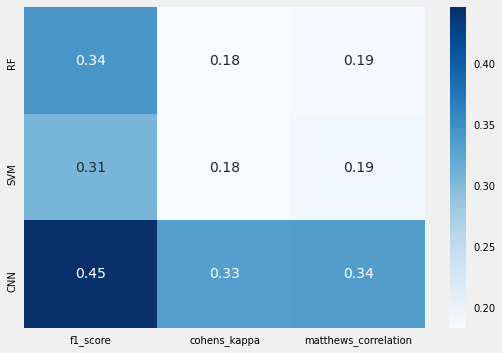

In [29]:
# Display all performance metrics
performance_table = pd.DataFrame(
    {'f1_score': [f1_rf, f1_svm, f1_cnn],
    'cohens_kappa': [cohen_rf, cohen_svm, cohen_cnn],
    'matthews_correlation': [matthews_rf, matthews_svm, matthews_cnn]},
    index=['RF', 'SVM', 'CNN'])
sns.heatmap(performance_table, cmap="Blues", annot=True)
plt.show()

# 4. Combine different model predictions (Stacking)

In [30]:
# Calculate for equal voting power
y_test_prob_equal = y_test_cnn_prob + y_test_rf_prob + y_test_svm_prob
y_test_equal = np.argmax(y_test_prob_equal, axis=1)

# Calculate with weighted voting power (i.e., CNN has twice as much power)
y_test_prob_w = y_test_cnn_prob*2 + y_test_rf_prob + y_test_svm_prob
y_test_w = np.argmax(y_test_prob_w, axis=1)

In [31]:
# Evaluate voting with same multiclass preformance metrics
print('Equal Voting Power')
print(classification_report(y_test, y_test_equal,
                               target_names=c_labels))
print('Weighted Voting Power (Double CNN)')
print(classification_report(y_test, y_test_w,
                               target_names=c_labels))

# Calculate f1-scores
f1_equal = np.mean(f1_score(y_test, y_test_equal, average=None))
f1_w = np.mean(f1_score(y_test, y_test_w, average=None))

cohen_equal = cohen_kappa_score(y_test, y_test_equal)
cohen_w = cohen_kappa_score(y_test, y_test_w)

# Calculate Matthews Correlation Coefficient
matthews_equal = matthews_corrcoef(y_test, y_test_equal)
matthews_w = matthews_corrcoef(y_test, y_test_w)

Equal Voting Power
               precision    recall  f1-score   support

  dried_basil       0.25      0.07      0.11        15
dried_oregano       0.14      0.13      0.14        15
dried_parsley       0.53      0.53      0.53        15
  dried_thyme       0.24      0.33      0.28        15
    non_spice       0.62      0.87      0.72        15

     accuracy                           0.39        75
    macro avg       0.36      0.39      0.36        75
 weighted avg       0.36      0.39      0.36        75

Weighted Voting Power (Double CNN)
               precision    recall  f1-score   support

  dried_basil       0.18      0.13      0.15        15
dried_oregano       0.20      0.13      0.16        15
dried_parsley       0.53      0.60      0.56        15
  dried_thyme       0.28      0.33      0.30        15
    non_spice       0.68      0.87      0.76        15

     accuracy                           0.41        75
    macro avg       0.37      0.41      0.39        75
 weigh

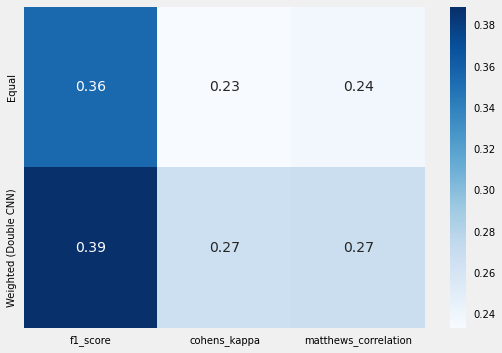

In [32]:
# Display performance table with voting scores
performance_table = pd.DataFrame(
    {'f1_score': [f1_equal, f1_w],
    'cohens_kappa': [cohen_equal, cohen_w],
    'matthews_correlation': [matthews_equal, matthews_w]},
    index=['Equal', 'Weighted (Double CNN)'])
fig, ax = plt.subplots()
sns.heatmap(performance_table, cmap="Blues", annot=True, ax=ax)
ax.set_yticklabels(performance_table.index, va='center')
plt.show()

# 5. Create Final Pipeline

In [42]:
# Prepare raw input image for prediction by resizing and converting to array
img = Image.open('./model_dataset/test/dried_basil/basil13.jpg')
img = img.convert('RGB')
resized_img = img.resize((200, 200))
array_img = np.array(resized_img)
array_img = np.expand_dims(array_img, axis=0)

# Extract features, predict with the three models, and final ensemble prediction
extracted_feat = feat_extract(array_img)
rf_pred = rfc.predict_proba(extracted_feat)
svm_pred = svm.predict_proba(extracted_feat)
cnn_pred = vgg16.predict(array_img)
pred = cnn_pred*2 + rf_pred + svm_pred

# Convert number prediction to string
class_labels = ['Dried Basil', 'Dried Oregano', 'Dried Parsley', 'Dried Thyme', 'Not a Spice']
class_pred = class_labels[np.argmax(pred)]

print(f'Prediction: {class_pred}')

Prediction: Dried Parsley


# 6. Save ML Models

In [38]:
# Pickle small models but save large models (i.e., cnn)
pickle.dump(svm, open('svm_model.pkl', 'wb'))
pickle.dump(rfc, open('rf_model.pkl', 'wb'))
feat_extract.save('feat_extract.h5')
vgg16.save('cnn_model.h5')